In [1]:
%%capture
%pip install opencv-python
%pip install tqdm
%pip install tensorflow
%pip install imageio
%pip install tensorflow_docs
%pip install scikit-learn
%pip install matplotlib

In [2]:
# %%python -m pip install opencv-python
%pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to c:\users\bhuynh26\appdata\local\temp\pip-req-build-mm15kruc
  Resolved https://github.com/tensorflow/docs to commit 60abeb06e500fa5edbbac374fc0d8142c8322aef
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\bhuynh26\AppData\Local\Temp\pip-req-build-mm15kruc'


In [2]:
import random
import pathlib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import itertools
from pathlib import Path
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import tensorflow as tf
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed
from tensorflow.keras.metrics import Precision, Recall

In [3]:
subset_paths = {}
subset_paths['train'] = Path('../Data/train')
subset_paths['test'] = Path('../Data/test')
subset_paths['val'] = Path('../Data/val')

In [4]:
def format_frames(frame, output_size):
    """
      Pad and resize an image from a video.

      Args:
        frame: Image that needs to resized and padded.
        output_size: Pixel size of the output frame image.

      Return:
        Formatted frame with padding of specified output size.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [5]:

def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=15):
    """
      Creates frames from each video file present for each category.

      Args:
        video_path: File path to the video.
        n_frames: Number of frames to be created per video file.
        output_size: Pixel size of the output frame image.

      Return:
        An NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

In [6]:

class FrameGenerator:
    def __init__(self, path, n_frames, training=False):
        """ Returns a set of frames with their associated label.

          Args:
            path: Video file paths.
            n_frames: Number of frames.
            training: Boolean to determine if training dataset is being created.
        """
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(
            set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx)
                                       for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.mp4'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames)
            label = self.class_ids_for_name[name]  # Encode labels
            yield video_frames, label


In [7]:
output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype=tf.int16))

In [8]:
train_ds = tf.data.Dataset.from_generator(FrameGenerator(
    subset_paths['train'], 6, training=True),                                        output_signature=output_signature)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 6),
                                        output_signature=output_signature)

# create the test set
test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], 6),
                                         output_signature=output_signature)

In [9]:
train_frames, train_labels = next(iter(train_ds))
val_frames, val_labels = next(iter(val_ds))

In [10]:
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of validation set of frames: (6, 224, 224, 3)
Shape of validation labels: ()


In [11]:
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

Shape of training set of frames: (6, 224, 224, 3)
Shape of training labels: ()


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


In [13]:
batch_size = 3
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [14]:
net = tf.keras.applications.EfficientNetB0(include_top=False)
net.trainable = False

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [16]:
metrics = [tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()]


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

In [18]:
history = model.fit(train_ds,
          epochs=10,
          validation_data=val_ds,
          callbacks=tf.keras.callbacks.EarlyStopping(patience=2, monitor='binary_accuracy', mode='max', restore_best_weights=True))

Epoch 1/10


228/228 [==============================] - 71s 312ms/step - loss: 0.1192 - auc: 0.9835 - recall: 0.8509 - precision: 0.9065 - binary_accuracy: 0.9605 - true_positives: 97.0000 - true_negatives: 560.0000 - false_negatives: 17.0000 - false_positives: 10.0000 - val_loss: 0.0934 - val_auc: 0.9924 - val_recall: 0.8684 - val_precision: 0.9167 - val_binary_accuracy: 0.9651 - val_true_positives: 33.0000 - val_true_negatives: 188.0000 - val_false_negatives: 5.0000 - val_false_positives: 3.0000
Epoch 2/10
228/228 [==============================] - 72s 318ms/step - loss: 0.0862 - auc: 0.9913 - recall: 0.8860 - precision: 0.9266 - binary_accuracy: 0.9693 - true_positives: 101.0000 - true_negatives: 562.0000 - false_negatives: 13.0000 - false_positives: 8.0000 - val_loss: 0.0908 - val_auc: 0.9921 - val_recall: 0.8421 - val_precision: 0.9143 - val_binary_accuracy: 0.9607 - val_true_positives: 32.0000 - val_true_negatives: 188.0000 - val_false_negatives: 6.0000 - val_false_positives: 3.0000
Epoch 3/1

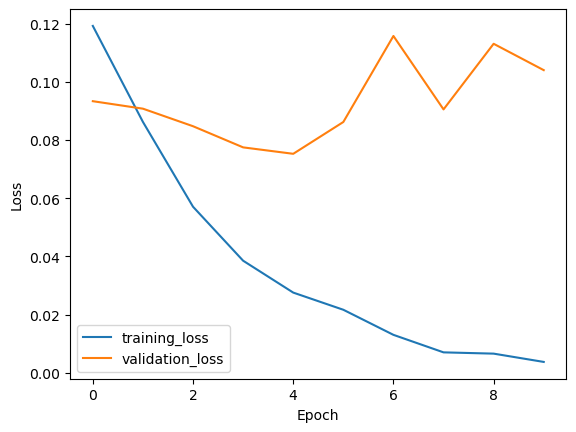

'\nTODO: \nThe validation_loss is increasing which could mean the model is overfitting.\nWorking on adjusting stopping parameters.\n'

In [19]:
# Plot training history
import matplotlib.pyplot as plt

# Access the training history from the 'history' object
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')

# Label the axes and add a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

"""
TODO: 
The validation_loss is increasing which could mean the model is overfitting.
Working on adjusting stopping parameters.
"""

In [20]:
test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], 6),                                       output_signature=output_signature)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(2)
test_frames, test_labels = next(iter(test_ds))

In [21]:
y_pred  = model.predict(test_ds, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

114/114 [==============================] - 19s 148ms/step


In [22]:
from sklearn.metrics import classification_report

# Assuming test_ds is a TensorFlow dataset and y_pred_bool is a NumPy array
y_true_list = []
for data, labels in test_ds:
    y_true_list.extend(labels.numpy())

y_true = np.array(y_true_list)
y_pred_bool = np.array(y_pred_bool)


In [23]:
# y_pred_bool = np.where(y_pred_bool == 1, 'violence', 'nonviolence')
# y_true = np.where(y_true == 1, 'violence', 'nonviolence')

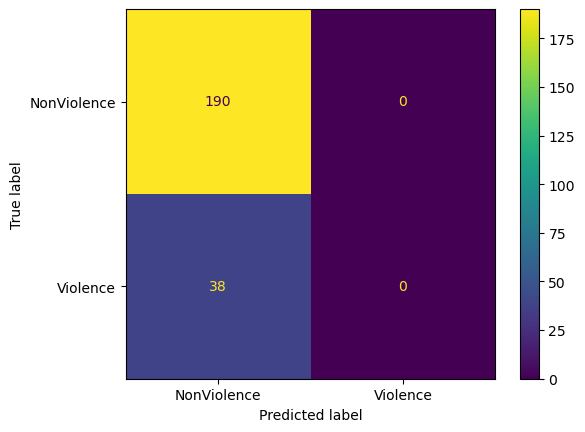

In [24]:
cm = confusion_matrix(y_true, y_pred_bool)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    'NonViolence' , 'Violence'
]).plot()

In [25]:
# NV = 0, V = 1
print(classification_report(y_true, y_pred_bool, target_names=['NonViolence', 'Violence']))

              precision    recall  f1-score   support

 NonViolence       0.83      1.00      0.91       190
    Violence       0.00      0.00      0.00        38

    accuracy                           0.83       228
   macro avg       0.42      0.50      0.45       228
weighted avg       0.69      0.83      0.76       228



c:\Users\bhuynh26\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bhuynh26\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\bhuynh26\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
